In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torchviz import make_dot

##### Data examples

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()  # 将图像转换为张量
])

# 加载训练集
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)


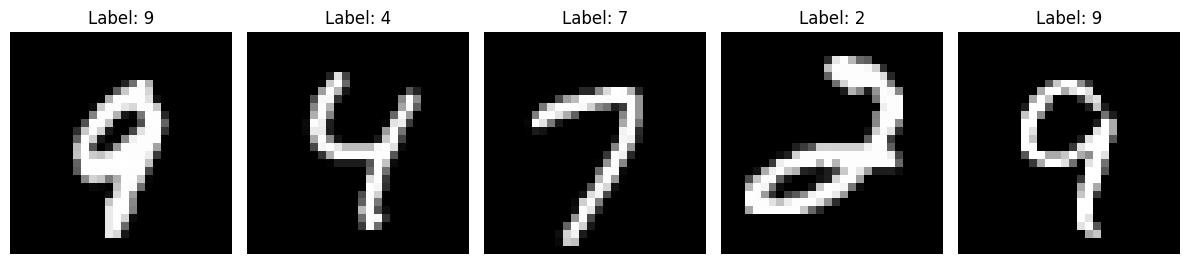

In [6]:
# 设置随机种子以确保结果可复现
random.seed(42)

# 随机选择一些图像的索引
num_samples = 5  # 选择5张图像
random_indices = random.sample(range(len(train_dataset)), num_samples)

# 创建一个子图画布
fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

# 显示随机选择的图像
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]  # 获取图像和标签
    axes[i].imshow(image.squeeze(), cmap='gray')  # 显示图像（去掉批次维度）
    axes[i].set_title(f"Label: {label}")  # 设置标题为标签
    axes[i].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

LeNet-5的架构如下：

输入层：32x32的灰度图像（MNIST图像会被调整为32x32）。

卷积层1：6个5x5的卷积核，输出6个28x28的特征图。

池化层1：2x2的最大池化，输出6个14x14的特征图。

卷积层2：16个5x5的卷积核，输出16个10x10的特征图。

池化层2：2x2的最大池化，输出16个5x5的特征图。

全连接层1：120个神经元。

全连接层2：84个神经元。

输出层：10个神经元（对应10个类别）。

In [14]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 卷积层1：输入1通道，输出6通道，卷积核5x5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # 池化层1：2x2最大池化
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积层2：输入6通道，输出16通道，卷积核5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # 池化层2：2x2最大池化
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层1：输入16*5*5=400，输出120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 全连接层2：输入120，输出84
        self.fc2 = nn.Linear(120, 84)
        # 输出层：输入84，输出10
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 卷积层1 + ReLU + 池化层1
        x = self.pool1(F.relu(self.conv1(x)))
        # 卷积层2 + ReLU + 池化层2
        x = self.pool2(F.relu(self.conv2(x)))
        # 展平操作
        x = x.view(-1, 16 * 5 * 5)
        # 全连接层1 + ReLU
        x = F.relu(self.fc1(x))
        # 全连接层2 + ReLU
        x = F.relu(self.fc2(x))
        # 输出层
        x = self.fc3(x)
        return x

MNIST数据集中的图像大小为28x28，而LeNet-5的输入要求是32x32。因此，我们需要将图像调整为32x32。

In [ ]:
# 数据预处理：将图像调整为32x32，转换为张量，并进行归一化
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 调整图像大小为32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST的均值和标准差
])

# 加载训练集和测试集
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)  # 使用交叉熵损失函数
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
torch.save(model.state_dict(), "./lenet5_mnist.pth")

##### 加载模型并进行预测

In [ ]:
model = LeNet5().to(device)
model.load_state_dict(torch.load("lenet5_mnist.pth"))
model.eval()

# 使用测试集中的数据进行预测
with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    print(f'Predicted: {pred[0].item()}, Actual: {target[0].item()}')